## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
import pathlib
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
sys.path.append("../") # go to parent dir
from make_plant_parts_eia import *
pd.options.display.max_columns = None

In [5]:
import pathlib
import deprish

In [6]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing objectDEBUG

In [7]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

In [8]:
table_compiler = CompileTables(pudl_engine, freq='AS', roll=True)

In [9]:
parts_compiler = CompilePlantParts(table_compiler,clobber=True)

In [10]:
plant_parts_df = parts_compiler.generate_master_unit_list(qual_records=True)

Generating the master generator table with ownership.
beginning the aggregation for generation_eia923
getting generation_eia923 from the sqlite db
beginning the aggregation for generators_eia860
getting generators_eia860 from the sqlite db
beginning the aggregation for mcoe
getting mcoe from the output object
filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages
getting ownership_eia860 from the sqlite db
getting boiler_generator_assn_eia860 from the sqlite db
getting generators_entity_eia from the sqlite db


../make_plant_parts_eia.py:783: UserWarning: ahh merge error! when adding denorm colunms to plant_gen_df we must get the same number of recordsog # of records: 435638 vs  end state #: 435908
  warnings.warn(


making the counts for: plant
making the counts for: plant_unit
making the counts for: plant_prime_mover
making the counts for: plant_technology
making the counts for: plant_prime_fuel
making the counts for: plant_ferc_acct
making the counts for: plant_gen
true grans found for plant: 70461
true grans found for plant_unit: 72850
true grans found for plant_prime_mover: 19657
true grans found for plant_technology: 25295
true grans found for plant_prime_fuel: 2605
true grans found for plant_ferc_acct: 23371
true grans found for plant_gen: 145074
begin aggregation for: plant_ferc_acct
getting plants_eia from the sqlite db
begin aggregation for: plant_prime_fuel
begin aggregation for: plant_technology
begin aggregation for: plant_prime_mover
begin aggregation for: plant_gen
begin aggregation for: plant_unit
begin aggregation for: plant
getting utilities_eia from the sqlite db


#### Check true granularity labeling

In [11]:
part_bools = parts_compiler.prep_part_bools(drop_extra_cols=False)

making the counts for: plant
making the counts for: plant_unit
making the counts for: plant_prime_mover
making the counts for: plant_technology
making the counts for: plant_prime_fuel
making the counts for: plant_ferc_acct
making the counts for: plant_gen
true grans found for plant: 70461
true grans found for plant_unit: 72850
true grans found for plant_prime_mover: 19657
true grans found for plant_technology: 25295
true grans found for plant_prime_fuel: 2605
true grans found for plant_ferc_acct: 23371
true grans found for plant_gen: 145074


In [12]:
plant_id_eia = 2049
df = part_bools

part_name = 'plant_unit'
peer_part_name = 'plant_prime_mover'
cols_bool = [f'{part_name}_has_only_one_{peer_part_name}',
             f'{peer_part_name}_has_only_one_{part_name}']
true_gran_cols = list(df.filter(like=f'true_gran_{part_name}').columns)
(df[(df.plant_id_eia == plant_id_eia)
    & (df.report_date.dt.year == 2018)
    & (df.ownership == 'owned')
   ]
 .set_index(parts_compiler.id_cols_list)
 [true_gran_cols + [f"appro_part_label_{part_name}"]]
 #[cols_bool + cols_true]
)

true_gran_plant_unit_v_plant  \
plant_id_eia generator_id unit_id_pudl technology_description               energy_source_code_1 prime_mover_code ferc_acct_name                                 
2049         1            NaN          Natural Gas Steam Turbine            NG                   ST               Steam                                   True   
             2            NaN          Natural Gas Steam Turbine            NG                   ST               Steam                                   True   
             3            3            Natural Gas Steam Turbine            NG                   ST               Steam                                   True   
             4            4            Natural Gas Steam Turbine            NG                   ST               Steam                                   True   
             5            5            Natural Gas Steam Turbine            NG                   ST               Steam                                   True   
             A            NaN          Natural Gas Fired Combustion Turbine NG                   GT               Other                                   True   

                                                                                                                                  true_gran_plant_unit  \
plant_id_eia generator_id unit_id_pudl technology_description               energy_source_code_1 prime_mover_code ferc_acct_name                         
2049         1            NaN          Natural Gas Steam Turbine            NG                   ST               Steam                           True   
             2            NaN          Natural Gas Steam Turbine            NG                   ST               Steam                           True   
             3            3            Natural Gas Steam Turbine            NG                   ST               Steam                           True   
             4            4            Natural Gas Steam Turbine            NG                   ST               Steam                           True   
             5            5            Natural Gas Steam Turbine            NG                   ST               Steam                           True   
             A            NaN          Natural Gas Fired Combustion Turbine NG                   GT               Other                           True   

                                                                                                                                 appro_part_label_plant_unit  
plant_id_eia generator_id unit_id_pudl technology_description               energy_source_code_1 prime_mover_code ferc_acct_name                              
2049         1            NaN          Natural Gas Steam Turbine            NG                   ST               Steam                           plant_unit  
             2            NaN          Natural Gas Steam Turbine            NG                   ST               Steam                           plant_unit  
             3            3            Natural Gas Steam Turbine            NG                   ST               Steam                           plant_unit  
             4            4            Natural Gas Steam Turbine            NG                   ST               Steam                           plant_unit  
             5            5            Natural Gas Steam Turbine            NG                   ST               Steam                           plant_unit  
             A            NaN          Natural Gas Fired Combustion Turbine NG                   GT               Other                           plant_unit

In [13]:
plant_id_eia = 2049
df = plant_parts_df
df[(df.plant_id_eia == plant_id_eia)
   & (df.report_date.dt.year == 2018)
  ]

,plant_id_eia,report_date,plant_part,generator_id,unit_id_pudl,prime_mover_code,energy_source_code_1,technology_description,ferc_acct_name,utility_id_eia,true_gran,appro_part_label,appro_record_id_eia,capacity_factor,capacity_mw,fraction_owned,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,operational_status,ownership,planned_retirement_date,plant_id_pudl,plant_name_eia,plant_name_new,record_count,total_fuel_cost,total_mmbtu,utility_id_pudl,utility_name_eia,report_year,plant_id_report_year
record_id_eia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2049_ng_2018_plant_prime_fuel_owned_12686,2049,2018-01-01,plant_prime_fuel,NaN,<NA>,NaN,NG,NaN,NaN,12686,False,plant,2049_2018_plant_owned_12686,0.127064,1215.5,1.0,3.880123,45.134625,gas,11.632266,1973,1352945.0,NaN,owned,NaT,660,Jack Watson,Jack Watson NG,1,6.031526e+07,1.554468e+07,190,Mississippi Power Co,2018,660_2018
2049_other_2018_plant_ferc_acct_owned_12686,2049,2018-01-01,plant_ferc_acct,A,<NA>,GT,NG,Natural Gas Fired Combustion Turbine,Other,12686,False,plant_prime_mover,2049_GT_2018_plant_prime_mover_owned_12686,0.000000,41.9,1.0,NaN,NaN,gas,NaN,1970,0.0,NaN,owned,NaT,660,Jack Watson,Jack Watson Other,2,0.000000e+00,0.000000e+00,190,Mississippi Power Co,2018,660_2018
2049_steam_2018_plant_ferc_acct_owned_12686,2049,2018-01-01,plant_ferc_acct,NaN,<NA>,ST,NG,Natural Gas Steam Turbine,Steam,12686,False,plant_prime_mover,2049_ST_2018_plant_prime_mover_owned_12686,0.131600,1173.6,1.0,3.880123,45.134625,gas,11.632266,1973,1352945.0,NaN,owned,NaT,660,Jack Watson,Jack Watson Steam,2,6.031526e+07,1.554468e+07,190,Mississippi Power Co,2018,660_2018
2049_gt_2018_plant_prime_mover_owned_12686,2049,2018-01-01,plant_prime_mover,A,<NA>,GT,NG,Natural Gas Fired Combustion Turbine,Other,12686,True,plant_prime_mover,2049_GT_2018_plant_prime_mover_owned_12686,0.000000,41.9,1.0,NaN,NaN,gas,NaN,1970,0.0,NaN,owned,NaT,660,Jack Watson,Jack Watson GT,2,0.000000e+00,0.000000e+00,190,Mississippi Power Co,2018,660_2018
2049_st_2018_plant_prime_mover_owned_12686,2049,2018-01-01,plant_prime_mover,NaN,<NA>,ST,NG,Natural Gas Steam Turbine,Steam,12686,True,plant_prime_mover,2049_ST_2018_plant_prime_mover_owned_12686,0.131600,1173.6,1.0,3.880123,45.134625,gas,11.632266,1973,1352945.0,NaN,owned,NaT,660,Jack Watson,Jack Watson ST,2,6.031526e+07,1.554468e+07,190,Mississippi Power Co,2018,660_2018
2049_1_2018_plant_gen_owned_12686,2049,2018-01-01,plant_gen,1,<NA>,ST,NG,Natural Gas Steam Turbine,Steam,12686,True,plant_gen,2049_1_2018_plant_gen_owned_12686,0.000000,93.8,1.0,NaN,NaN,gas,NaN,1957,0.0,NaN,owned,NaT,660,Jack Watson,Jack Watson 1,6,0.000000e+00,0.000000e+00,190,Mississippi Power Co,2018,660_2018
2049_2_2018_plant_gen_owned_12686,2049,2018-01-01,plant_gen,2,<NA>,ST,NG,Natural Gas Steam Turbine,Steam,12686,True,plant_gen,2049_2_2018_plant_gen_owned_12686,0.000000,93.8,1.0,NaN,NaN,gas,NaN,1960,0.0,NaN,owned,NaT,660,Jack Watson,Jack Watson 2,6,0.000000e+00,0.000000e+00,190,Mississippi Power Co,2018,660_2018
2049_3_2018_plant_gen_owned_12686,2049,2018-01-01,plant_gen,3,3,ST,NG,Natural Gas Steam Turbine,Steam,12686,False,plant_unit,2049_3_2018_plant_unit_owned_12686,0.009617,108.8,1.0,3.880123,NaN,gas,NaN,1962,9166.0,retired,owned,NaT,660,Jack Watson,Jack Watson 3,6,0.000000e+00,0.000000e+00,190,Mississippi Power Co,2018,660_2018
2049_4_2018_plant_gen_owned_12686,2049,2018-01-01,plant_gen,4,4,ST,NG,Natural Gas Steam Turbine,Steam,12686,False,plant_unit,2049_4_2018_plant_unit_owned_12686,0.125900,299.2,1.0,3.880123,46.857903,gas,12.076396,1968,329984.0,NaN,owned,NaT,660,Jack Watson,Jack Watson 4,6,1.546236e+07,3.985017e+06,190,Mississippi Power Co,2018,660_2018


In [14]:
plant_parts_df.to_csv('master_unit_list.csv')
plant_parts_df.to_pickle('master_unit_list.pkl.gz')

In [15]:
compiled_plant_parts = {}
compiled_plant_parts_true = {}
true_parts_df = plant_parts_df[plant_parts_df.true_gran]
for part in parts_compiler.plant_parts.keys():
    part_df = plant_parts_df[(plant_parts_df['plant_part'] == part)]
    compiled_plant_parts_true[part] = true_parts_df[(true_parts_df['plant_part'] == part)]
    compiled_plant_parts[part] = part_df

In [18]:
def plot_plant_vs_agg(compiled_plant_parts, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for plant_gran, df in compiled_plant_parts.items():
        if plant_gran != 'plant':
            field_plant = field+'_plant'
            field_gran = field+'_'+plant_gran
            try:
                merge_df = compiled_plant_parts['plant'].merge(df, on=['plant_id_eia', 
                                                                       'report_date',
                                                                       'utility_id_eia',
                                                                       'ownership'
                                                                      ], suffixes=('_plant','_' + plant_gran))
                # this is for the try
                merge_df[field_gran]
                #merge_df = merge_df[merge_df['plant_id_eia'] == 3]
                fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
                ax.scatter(merge_df[field_plant],
                           merge_df[field_gran],
                           color='black', alpha=0.1, label=field)
                ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xscale(scale)
                ax.set_yscale(scale)
                ax.set_ylabel(f'{plant_gran} {field}')
                ax.set_xlabel(f'Plant {field}')
                ax.set_title(f"Plant vs {plant_gran}: {field}")
            except KeyError:
                pass

<ipython-input-18-61b4c24db94c>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))


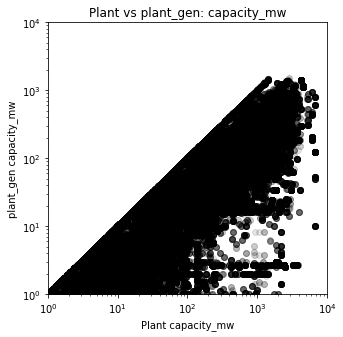

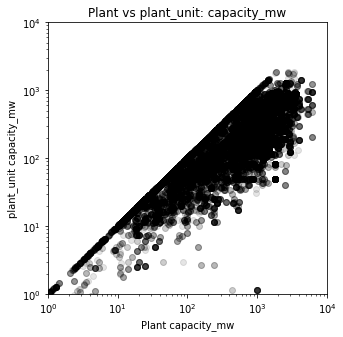

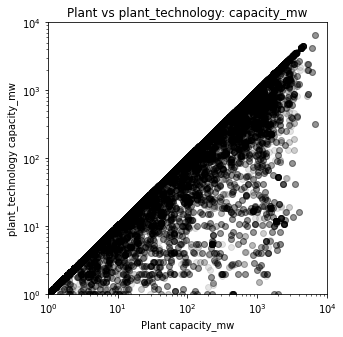

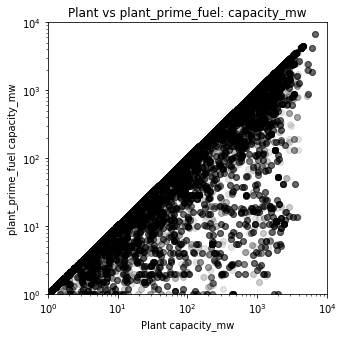

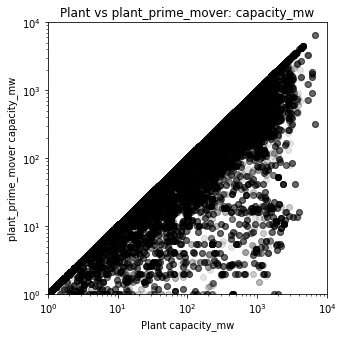

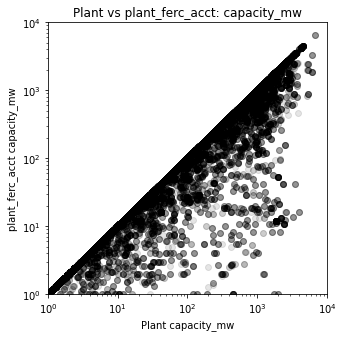

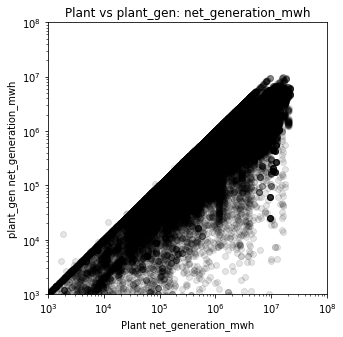

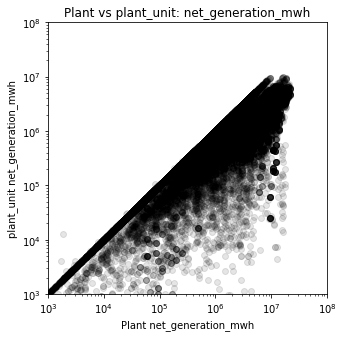

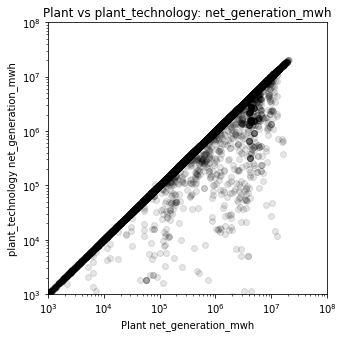

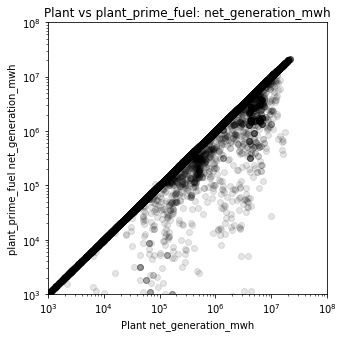

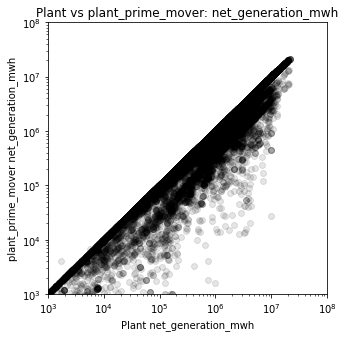

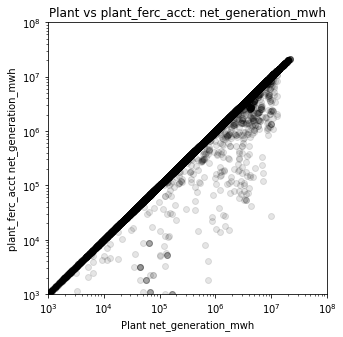

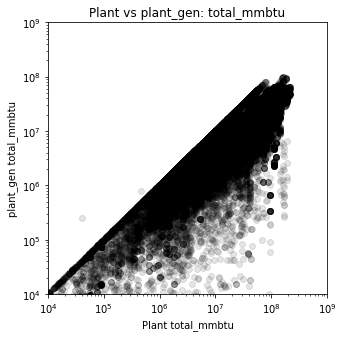

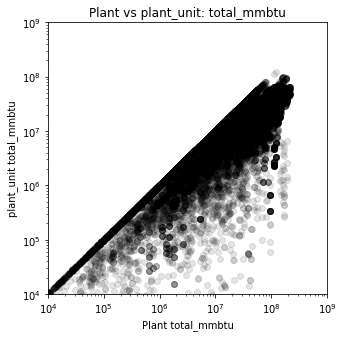

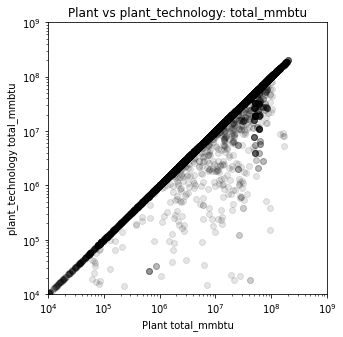

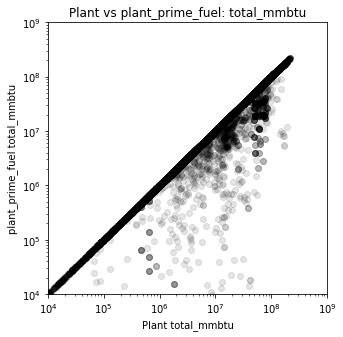

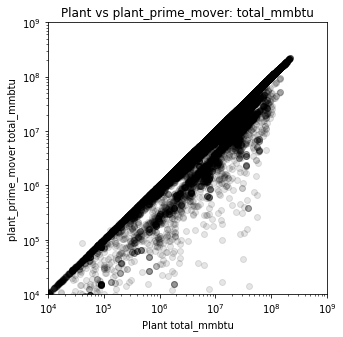

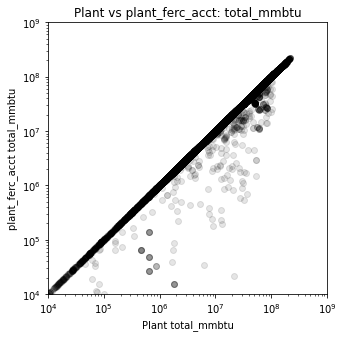

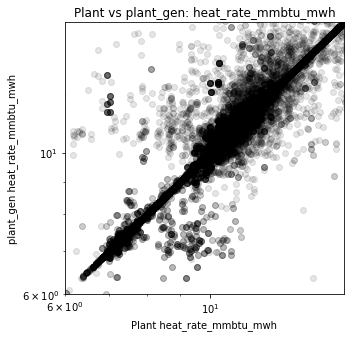

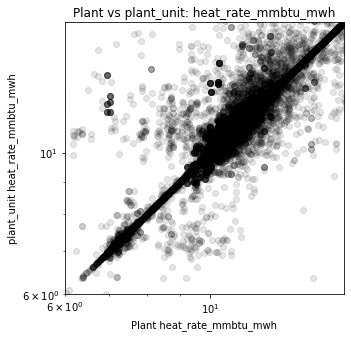

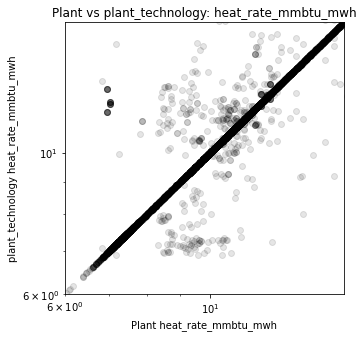

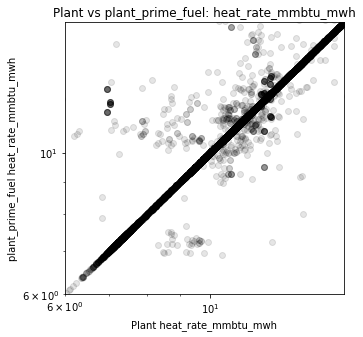

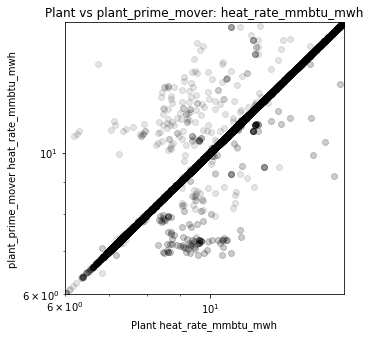

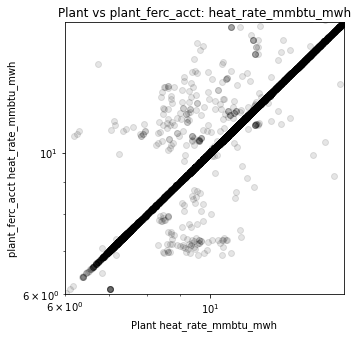

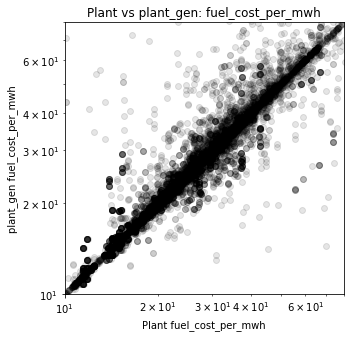

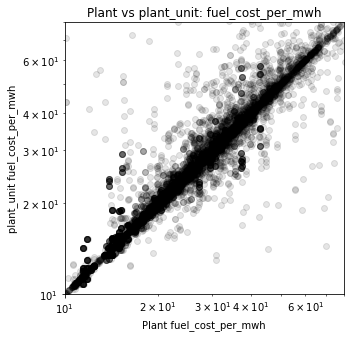

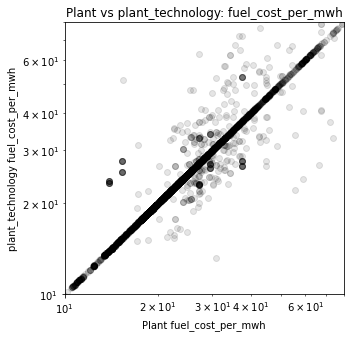

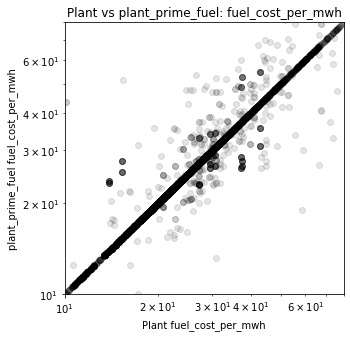

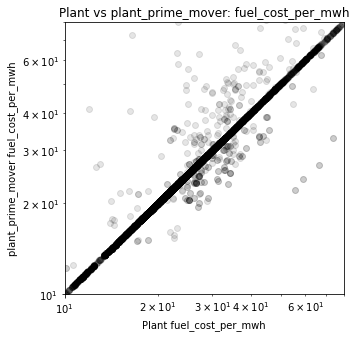

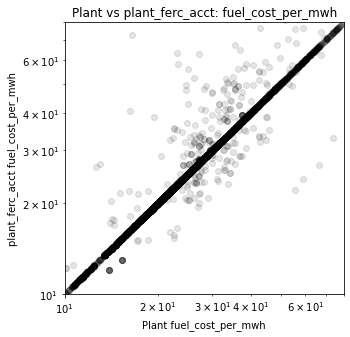

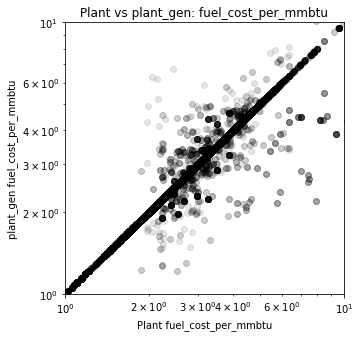

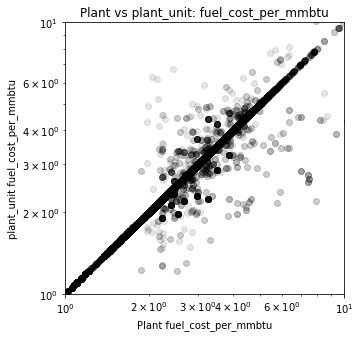

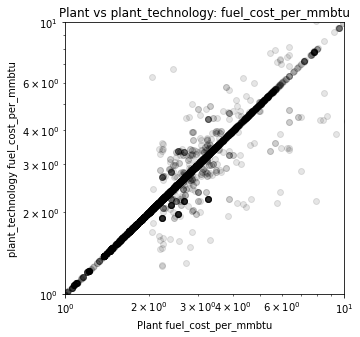

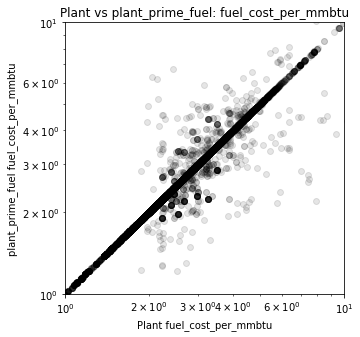

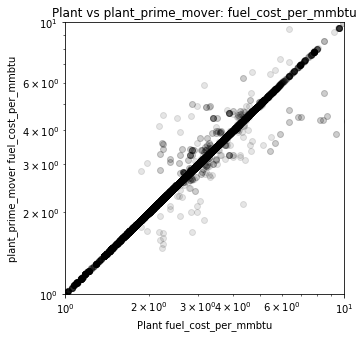

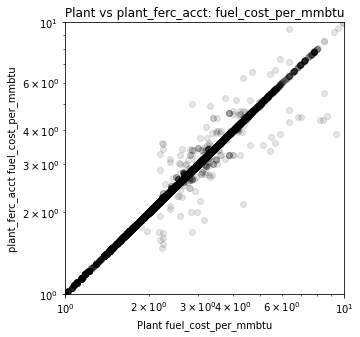

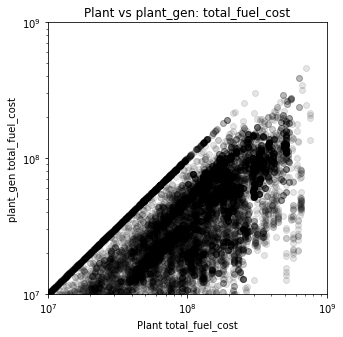

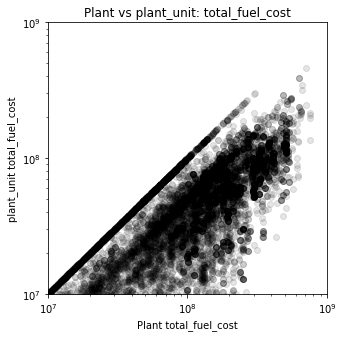

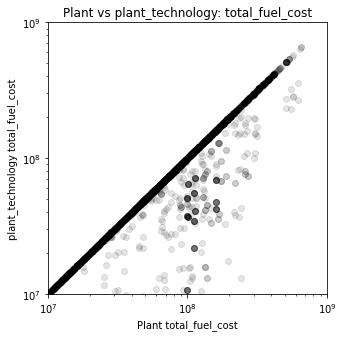

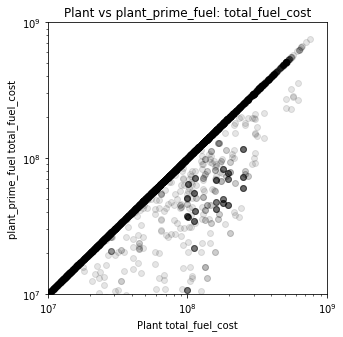

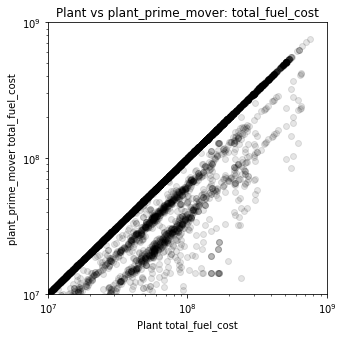

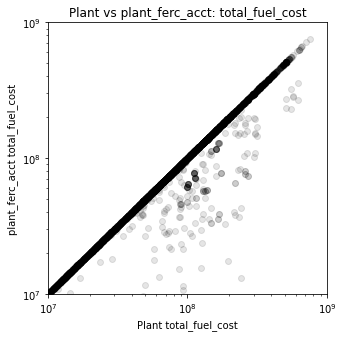

In [19]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    'net_generation_mwh',
    'total_mmbtu',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
    'total_fuel_cost'
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    'total_mmbtu': (1e4,1e9),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (1e0,1e1),
    'total_fuel_cost': (1e7,1e9)
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_plant_parts,field, xy_limits, scale="log")

In [20]:
def plot_gens_vs(compiled_plant_parts,part_name, data_col, weight_col, x_range):
    gen_df = compiled_plant_parts['plant_gen'][compiled_plant_parts['plant_gen'][data_col] != 0]
    part_df = compiled_plant_parts[part_name][compiled_plant_parts[part_name][data_col] != 0]
    if weight_col:
        weights_gen = gen_df[weight_col]
        weights_part = part_df[weight_col]
    else:
        weights_gen = None
        weights_part = None

    plt.hist(gen_df[data_col], 
             weights=weights_gen,
             range=x_range,
             bins=100,
             color="purple", #alpha=test_alpha,
             label="Generators")

    plt.hist(part_df[data_col], 
             weights=weights_part,
             range=x_range,
             bins=100,
             color="black",
             label=f'{part_name}')

    plt.title(f'Gens vs. {part_name}: {data_col}')
    plt.xlabel(data_col)
    plt.ylabel(None)
    plt.legend()
    plt.show()

In [21]:
x_ranges = {
    'capacity_mw' : (0,400),
    'net_generation_mwh': (0, 2500000),
    'fuel_cost_per_mmbtu': (0, 5),
    'fuel_cost_per_mwh': (0, 100),
    'total_fuel_cost': (0,200000000)
}

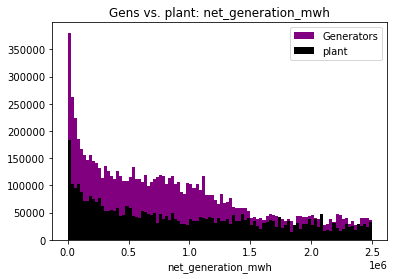

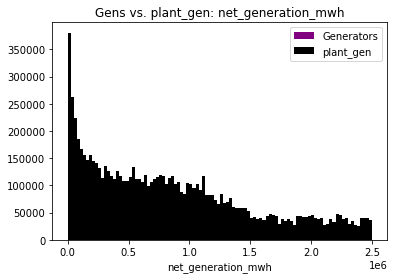

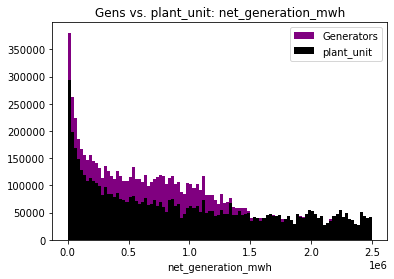

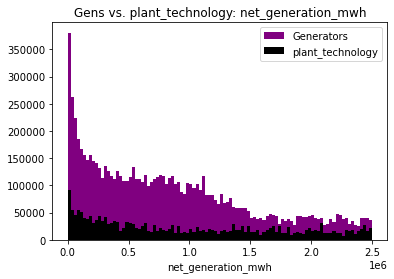

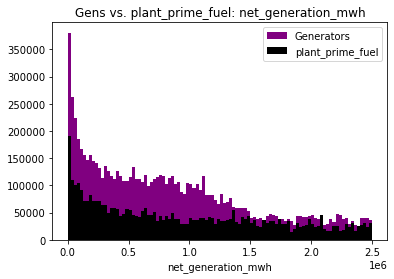

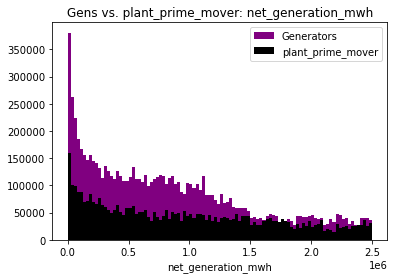

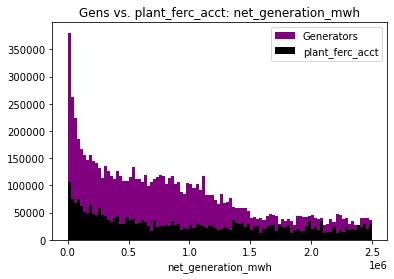

In [22]:
for part_name in compiled_plant_parts.keys():
    data_col =  'net_generation_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

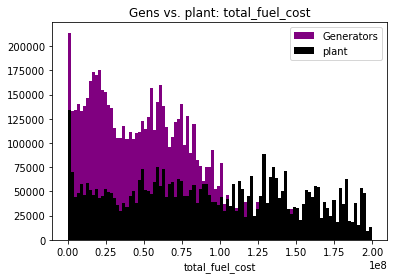

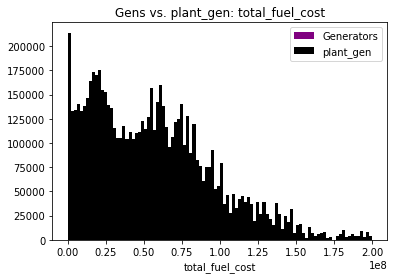

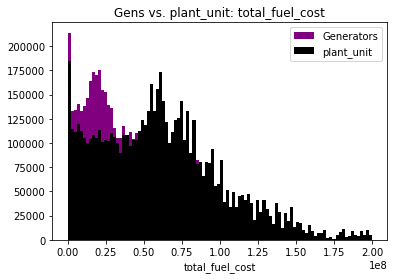

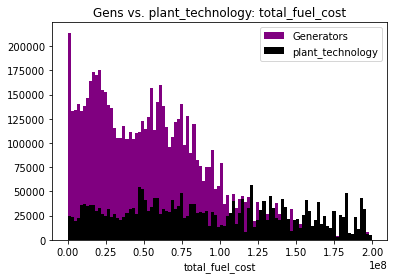

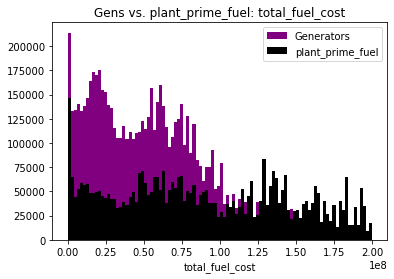

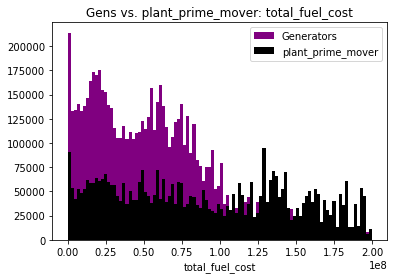

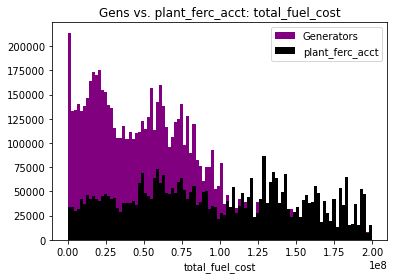

In [23]:
for part_name in compiled_plant_parts.keys():
    data_col =  'total_fuel_cost'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

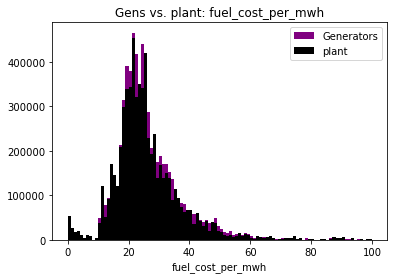

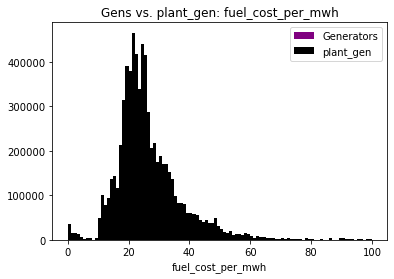

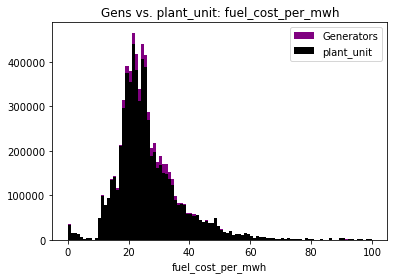

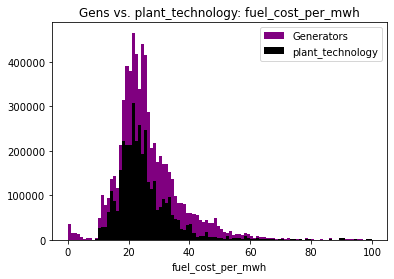

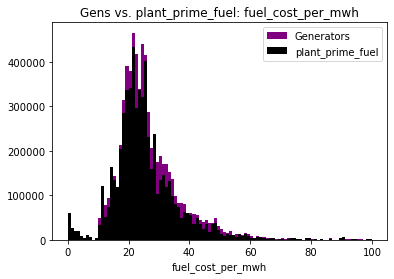

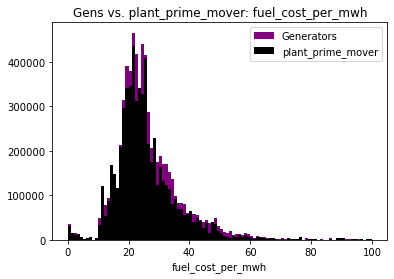

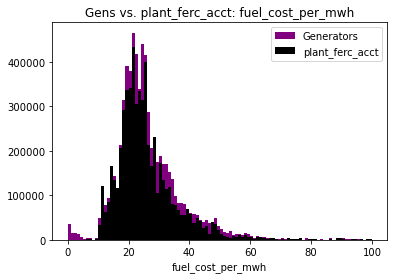

In [24]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

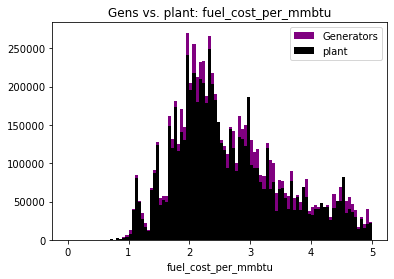

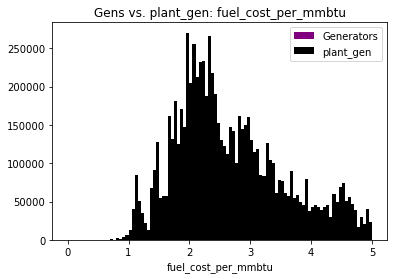

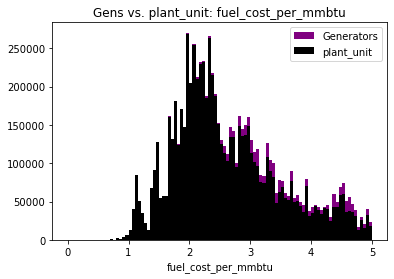

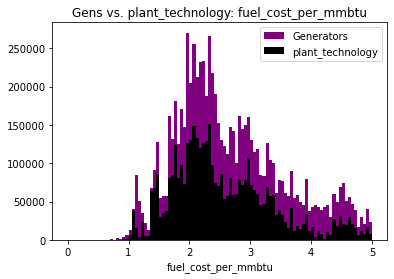

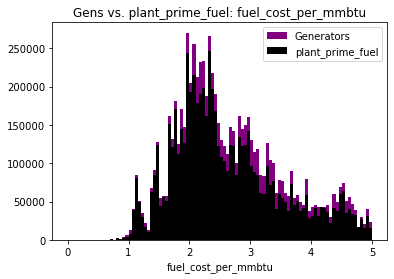

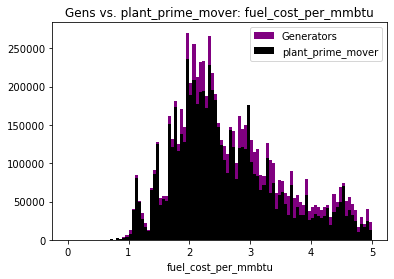

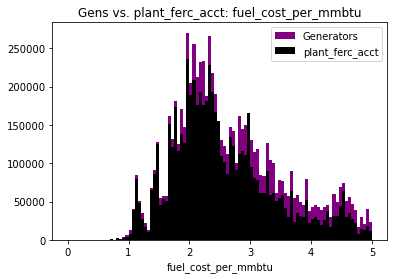

In [25]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mmbtu'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

## Playing with the compiled outputs 

In [26]:
null_zeros = {0:np.NaN}
count_df = pd.DataFrame(index=list(compiled_plant_parts['plant'].columns))
for k,cpp_df in compiled_plant_parts.items():
    cpp_df = cpp_df.replace({
        'net_generation_mwh':null_zeros,
        'capacity_factor' : null_zeros,
        'fuel_cost_per_mmbtu': null_zeros,
        'fuel_cost_per_mwh': null_zeros,
        'capacity_mw': null_zeros,
                        })
    count_df = count_df.merge(
        pd.DataFrame(cpp_df[cpp_df['report_date'].dt.year == 2018]
                     .count(), columns=[k]),
        right_index=True, left_index=True)
count_df = count_df.merge(pd.DataFrame(count_df.sum(axis=1),columns=['total']),
                          right_index=True, left_index=True)
count_df

,plant,plant_gen,plant_unit,plant_technology,plant_prime_fuel,plant_prime_mover,plant_ferc_acct,total
plant_id_eia,13715,37508,4728,15307,14994,16305,12934,115491
report_date,13715,37508,4728,15307,14994,16305,12934,115491
plant_part,13715,37508,4728,15307,14994,16305,12934,115491
generator_id,7089,37508,3560,8218,8052,9269,7020,80716
unit_id_pudl,1255,9214,4728,1718,1614,2648,1228,22405
prime_mover_code,11842,37433,3740,14261,13715,16305,11867,109163
energy_source_code_1,12524,37508,4698,15154,14994,15757,12389,113024
technology_description,12368,37508,4704,15307,14558,15868,12390,112703
ferc_acct_name,11224,31899,4385,13404,12902,14347,12934,101095
utility_id_eia,13715,37508,4728,15307,14994,16305,12934,115491
